## Imports and preprocessing

In [1]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace = True)
print(df.columns.tolist())
demand = df["demand"]
df = df[["X", "Y"]]
# df["Y"] -= 3000
data = df.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [3]:
total_demand = demand.sum()
capacity = 1200

## K-means

In [4]:
def cost(data, R, Mu):
    N, D = data.shape 
    K = Mu.shape[1] 
    J = 0
    for k in range(K):
        J += np.dot(np.linalg.norm(data - np.array([Mu[:, k], ] * N), axis=1)**2, R[:, k])

    return J

In [5]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities
    """
    
    N, D = data.shape 
    K =  Mu.shape[1] 
    r = np.zeros((N, K)) 
    for k in range(K):
      r[:, k] = np.linalg.norm(data - np.array([Mu[:, k], ]*N), axis=1)**2

    arg_min = np.argmin(r, axis=1) 
    R_new = np.zeros((N, K)) 
    R_new[np.arange(N), arg_min] = 1 
    return R_new

In [6]:
# TODO: K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D =  data.shape 
    K = Mu.shape[1] 
    Mu_new =  (np.matmul(data.T, R))/np.sum(R, axis=0) # TODO
    return Mu_new

In [7]:
N, D = data.shape 
K = total_demand//capacity
if K * capacity < total_demand:
    K += 1
max_iter = 100
d = demand.to_numpy()

def capacitated_k_means(data, K, N, D, max_iter, demand):
    R = np.zeros((N, K))
    idx = np.random.choice(data.shape[0], size=K, replace=False)
    Mu = np.zeros([D, K])
    for i in range(K):
        Mu[:, i] = data[idx[i]]

    for it in range(max_iter):
        R = km_assignment_step(data, Mu) 
        Mu = km_refitting_step(data, R, Mu) 
    return Mu, R

In [8]:
Mu, R = capacitated_k_means(data, K, N, D, max_iter, d)

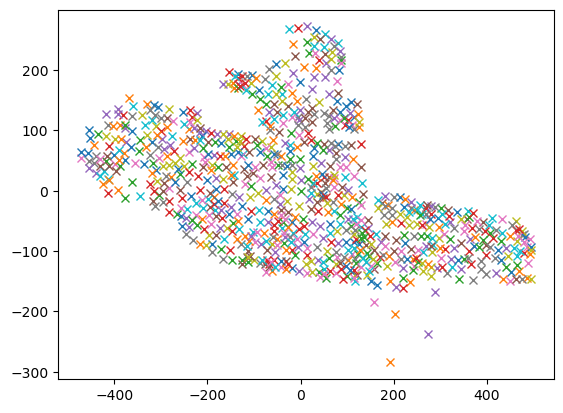

In [9]:
Mu_backup = np.copy(Mu)
R_backup = np.copy(R)
# for i in range(R.shape[1]):
#     cluster = np.where(R[:, i]) 
#     plt.plot(data[cluster][:, 0], data[cluster][:, 1], "x")
for i in range(Mu.shape[1]):
    plt.plot(Mu[0][i], Mu[1][i], "x")

In [14]:
# Mu.shape
np.savetxt('Kmeans_cluster.csv', Mu.T, delimiter=',', header="x,y")

## Post Processing

How to run this.

new_demand are demands that cannot be fullfilled by its assigned depot
new_capacities are available depots and their remaining capacities
non_trivial_demand and empty_facilities are lists of indices to index into new_demand and new_capacities respectively. 

random_search(node, total_demand, empty_facilities, num_empty) is the neighbour function in SA as well as how to generate the initial solution. The node is the node in the graph, and the total demand is the demand at this node. empty_facilities is defined above. num_empty is the number of empty facilities

It has two possiblities, rand_search and backup_search. rand_search generate the a random vector of the dimension of empty facilities and it sums up to the total demand of the node. If by random generation results in violation of capacity restraint, we use backupsearch where we partition the node's demand into the closest depot(s) to it. 

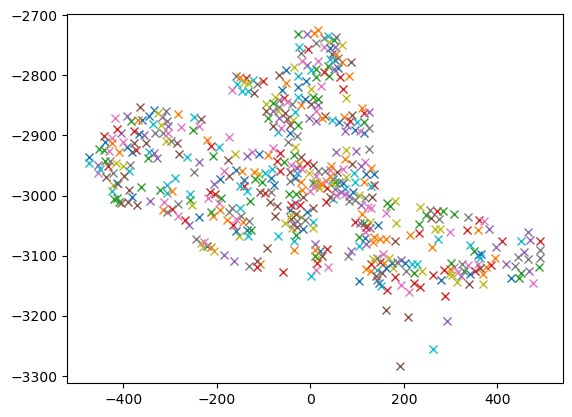

In [10]:
# capacity = 1200
# dpc = d.dot(R)
# utilization = np.where(dpc >= capacity, False, True)
# not_overloaded_facilities = Mu[:,utilization]
# for i in range(not_overloaded_facilities.shape[1]):
#     plt.plot(not_overloaded_facilities[0][i], not_overloaded_facilities[1][i], "x")

In [11]:
# new_demand = d.copy().astype(np.int64)
# capacities = 1200*np.ones(K)
# for i in range(K):
#     extra = 0
#     indices = np.where(R_backup[:,i])[0]
#     capacities[i] -= dpc[i]
#     if capacities[i] >= 0:
#         new_demand[indices]= 0
#     else:
#         capacities[i] = 1200
#         priority_list = np.argsort(-new_demand[indices])
#         for j in priority_list:
#             if capacities[i] <= new_demand[indices[j]]:
#                 R[:, i][indices[j]] = capacities[i]
#                 new_demand[indices[j]] -= capacities[i]
#                 capacities[i] = 0
#                 break
#             else:
#                 R[:, i][indices[j]] = new_demand[indices[j]]
#                 capacities[i] -= new_demand[indices[j]]
#                 new_demand[indices[j]] = 0

# new_demand = np.where(new_demand > 0, new_demand, 0).astype(np.int64)
# new_capacities = np.where(capacities > 0, capacities, 0).astype(np.int64)
# non_trivial_demand = np.nonzero(new_demand)[0]
# empty_facilities = np.nonzero(new_capacities)[0]
# num_empty = empty_facilities.shape[0]

In [12]:
# R[:,i].shape
# np.sum(new_capacities)

313579

In [13]:
# np.sum(new_demand)

312779

In [14]:
# import math
# import random
# def exp_schedule(k=20, lam=0.005, limit=100):
#     function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
#     return function

# def backup_search(node, total_demand, empty_facilities, num_empty):
#     result = np.zeros(K)
#     facilities = Mu.T[empty_facilities[:]]
#     costs = np.linalg.norm(facilities - node, axis=1)
#     assert(costs.shape[0] == num_empty)
#     cost = 0
#     min_cost_depot = np.argsort(costs)
#     for j in min_cost_depot:
#         if new_capacities[empty_facilities[j]] >= total_demand:
#             cost += costs[j]
#             result[empty_facilities[j]] += total_demand
#             break
#         else:
#             cost += costs[j]
#             result[empty_facilities[j]] += new_capacities[empty_facilities[j]]
#             total_demand -= new_capacities[empty_facilities[j]]
#         if total_demand <= 0:
#             break
    
#     return result, cost

# def rand_search(node, total_demand, empty_facilities, num_empty):
#     assert(total_demand>= 1)
#     how_many = random.randint(1, min(empty_facilities.shape[0], total_demand))
#     indices = np.random.choice(empty_facilities.shape[0], size=how_many, replace=False)
#     result = np.zeros(K)
#     facilities = Mu.T[empty_facilities[indices]]
#     cost = 0
#     for i in facilities:
#         cost += np.linalg.norm(i - node)
#     result[empty_facilities[indices]] = np.random.multinomial(total_demand, np.random.dirichlet(np.ones(how_many) * 0.1))
#     return result, cost

# def random_search(node, total_demand, empty_facilities, num_empty):
#     if num_empty <= 1:
#         return backup_search(node, total_demand, empty_facilities, num_empty)
#     result, cost = rand_search(node, total_demand, empty_facilities, num_empty)
#     if np.any(new_capacities < result):
#         return backup_search(node, total_demand, empty_facilities, num_empty)
#     return result, cost

In [15]:
# backup_search(data[non_trivial_demand[0]], new_demand[non_trivial_demand[0]], empty_facilities, num_empty)

In [16]:
# print(new_demand[non_trivial_demand[0]]) 
# random_search(data[non_trivial_demand[0]], new_demand[non_trivial_demand[0]], empty_facilities, num_empty)

135


In [17]:
# from smart_mobility_utilities.common import probability
# num_iterations = 100
# exp_schedule_k = 100
# exp_schedule_lam = 0.005
# def simulated_annealing(initial_solution, num_iter, schedule_function, neighbour_function, node, total_demand, empty_facilities, num_empty):
#     current, current_cost = initial_solution
#     states = [current_cost]
    
#     for t in range(num_iter):
#         T = schedule_function(t)
#         next_choice, next_cost = neighbour_function(node, total_demand, empty_facilities, num_empty)
#         current_cost = states[-1]
#         delta_e = next_cost - current_cost
#         if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
#             current = next_choice
#             states.append(next_cost)
#     return current, states[-1], states

In [18]:
# schedule = exp_schedule(exp_schedule_k, exp_schedule_lam, num_iterations)
# initial_solution = random_search(data[non_trivial_demand[0]], new_demand[non_trivial_demand[0]], empty_facilities, num_empty)
# #
# print (f"Initial Solution: {initial_solution[0]}")
# print(f"Initial Cost: {initial_solution[1]}")
# best_solution_origin_d1, best_cost_origin_d1, states = simulated_annealing(
#     initial_solution,
#     num_iterations,
#     schedule,
#     random_search,
#     data[non_trivial_demand[0]],
#     new_demand[non_trivial_demand[0]],
#     empty_facilities,
#     num_empty
# )

In [19]:
# new_demand[non_trivial_demand[-1]]

In [20]:
# best_cost_origin_d1
# plt.plot(states)

In [21]:
# new_capacities = back_up_point
# empty_facilities = backup_empty_facility

In [22]:
# new_capacities

array([ 929,   61,  402,  463,  253,    0,    0,    0,    0, 1200,   81,
       1058, 1038,    0,    0,  542,    0,  887,    0,  973,    0, 1032,
          0,    0,    0,  563,  673,  782,    0,    0,  635,  450, 1005,
       1053,    0,  855,  302,  784,    0,    0,  357,    0,  586,    0,
         22,    0,    0,  190, 1075,   15,  394,  118,  238,  646,    0,
        337,   52,  507,    0,   75,  733,  664,  776,  817,    0,  497,
        287,  326,  951,  257,  160,    0,    0,  487,    0,  398,  747,
        247,  406,    3,    0,  129,  301,  888,    0,  256,  261,    0,
        304,    0,    0,  710,  842,  347,  759, 1195,    0,  516,  419,
        106,    0,    0,  174,    0, 1021,  748,    0,  712,    0,    0,
        966,  775,  112,    0,   79,  943,  619,    0,  185,  385,  615,
        964,  387,  933,  549, 1199,    0,    0,    0,  197,  457,    0,
        391,  412,  408,  470,  585,  189,  982,    0,  848,    0,    0,
        291,  524,  543, 1078,    0,  444,    0,  1

In [ ]:
# back_up_point = np.copy(new_capacities)
# backup_empty_facility = np.copy(np.nonzero(new_capacities)[0])

# distribution_solution = np.zeros([non_trivial_demand.shape[0], K])
# num_iterations = 100
# exp_schedule_k = 100
# exp_schedule_lam = 0.005
# total_cost = 0
# for i in range(non_trivial_demand.shape[0]):
#     schedule = exp_schedule(exp_schedule_k, exp_schedule_lam, num_iterations)
#     initial_solution = random_search(data[non_trivial_demand[i]], new_demand[non_trivial_demand[i]], empty_facilities, num_empty)
#     best_solution_origin_d1, best_cost_origin_d1, states = simulated_annealing(
#         initial_solution,
#         num_iterations,
#         schedule,
#         random_search,
#         data[non_trivial_demand[i]],
#         new_demand[non_trivial_demand[i]],
#         empty_facilities,
#         num_empty
#     )
#     new_capacities -= best_solution_origin_d1.astype(np.int64)
#     print(new_capacities.sum())
#     empty_facilities = np.nonzero(new_capacities)[0]
#     num_empty = empty_facilities.shape[0]
#     distribution_solution[i] = best_solution_origin_d1
#     total_cost += best_cost_origin_d1

313444
313304
313147
313008
312920
312875
312823
312761
312698
312553
312430
312324
312228
312094
311990
311868
311194
310848
310743
310536
310514
310170
310043
309891
309766
309624
308822
308341
307886
307559
307337
307083
306765
306441
306166
305865
305562
305515
305333
305137
304983
304829
304683
304618
304539
304537
304465
304104
304073
303609
303150
302665
302512
302372
302146
301947
301861
301761
301695
301352
301029
300708
300522
300327
300069
299841
299618
299376
299100
298809
298523
298382
298254
298123
297980
297555
297385
297198
296933
296709
296647
296471
296296
296092
295974
295874
295769
295552
295530
295358
295198
295188
295050
294904
294786
294664
294345
294181
294052
293934
293840
293723
293559
293419
293408
293309
293184
293120
293073
292984
292854
292718
292609
292498
292386
292280
292239
292215
292061
291990
291895
291711
291527
291390
290877
290407
290343
290216
290204
290111
289746
289640
289499
289480
289318
289239
289067
288915
288871
288725
288567
288458
288437

In [ ]:
# total_cost

In [ ]:
# distribution_solution.shape

In [ ]:
# R[non_trivial_demand,:] = distribution_solution

In [ ]:
# with open('R.npy', 'wb') as f:
#     np.save(f, R)
# with open('Mu.npy', 'wb') as f:
#     np.save(f, Mu)
# with open('distribution.npy', 'wb') as f:
#     np.save(f, distribution_solution)

## Save the result

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/ece1724 project